# REINFORCE algorithm to solve the mountain car problem.

## Problem Setting

Quite straightforward. A car starts on a valley of a mountain and we need the algorithm to get it out of the valley into the destination. The mountain road is a function on the $\mathbb{R}^2$ space, the car's starting point and destination are points in this function.

Im guessing the parameters are the velocity of the car and its position (x, height) which need to be optimized.

Ok that is a huge blunder. The velocity is not manipulatable. We can only manipulate the force that we give the car. This is ultimately the parameter that needs to be tweaked using some probability distribution.

## Why the need for Policy Gradient Methods?

Since the action space is continuous, it is impossible to search for the best performing action from value based methods, even if we are able to calculate the values for each action. Hence DQN wont work for such a scenario, and we need to use REINFORCE.

## How to solve using Policy Gradient Methods?

So we need to give a probability distribution to $F$ at different states such that sampling from this distribution will help the cart reach the destination. One simple distribution we can always give $F$ is the Gaussian distribution, and parameterize the mean of the Gaussian (assuming variance = 1). This mean will decide how our policy behaves and will have to adjust to solve this problem. This can be done by the neural network, coming up with an appropriate mean to sample the actions from. This will be done by the policy gradient methods in the neural network to obtain the right mean value.

## Implementation (Mostly heavily GPT'd, but understanding the implementation)

In [27]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt

In [28]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # Learnable log std

    def forward(self, state):
        x = self.net(state)
        mean = self.mean(x)
        std = torch.exp(self.log_std)
        return mean, std

    def get_action(self, state):
        state = torch.from_numpy(state).float()
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        action = dist.sample()
        return action.clamp(-1, 1).detach().numpy(), dist.log_prob(action).sum()

In [29]:
class REINFORCEAgent:
    def __init__(self, env, gamma=0.99, lr=1e-3):
        self.env = env
        self.gamma = gamma
        self.policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.shape[0])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def discount_rewards(self, rewards):
        discounted = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            discounted.insert(0, R)
        return torch.tensor(discounted, dtype=torch.float32)

    def train_episode(self):
        log_probs = []
        rewards = []

        state, _ = self.env.reset()
        done = False
        truncated = False
        total_reward = 0

        while not done and not truncated:
            action, log_prob = self.policy.get_action(state)
            next_state, reward, done, truncated, _ = self.env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            total_reward += reward

        returns = self.discount_rewards(rewards)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = 0
        for log_prob, R in zip(log_probs, returns):
            loss += -log_prob * R

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return total_reward

In [30]:
def train_agent():
    env = gym.make("MountainCarContinuous-v0")
    agent = REINFORCEAgent(env)

    num_episodes = 1000
    rewards = []
    avg_rewards = []

    for episode in range(num_episodes):
        reward = agent.train_episode()
        rewards.append(reward)
        avg_reward = np.mean(rewards[-50:])
        avg_rewards.append(avg_reward)

        print(f"Episode {episode + 1}: Reward = {reward:.2f}, Avg(50) = {avg_reward:.2f}")
        if avg_reward >= 90.0:
            print("Environment solved!")
            break

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Reward', color='tab:blue', alpha=0.6)
    plt.plot(avg_rewards, label='Avg Reward (50)', color='tab:orange', linewidth=2)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.title('REINFORCE with Baseline on MountainCarContinuous', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50))
    plt.tight_layout()
    plt.show()

Episode 1: Reward = -51.66, Avg(50) = -51.66
Episode 2: Reward = -52.80, Avg(50) = -52.23
Episode 3: Reward = -50.64, Avg(50) = -51.70
Episode 4: Reward = -55.27, Avg(50) = -52.59
Episode 5: Reward = -52.08, Avg(50) = -52.49
Episode 6: Reward = -50.96, Avg(50) = -52.24
Episode 7: Reward = -52.01, Avg(50) = -52.20
Episode 8: Reward = -50.93, Avg(50) = -52.05
Episode 9: Reward = -53.57, Avg(50) = -52.22
Episode 10: Reward = -54.26, Avg(50) = -52.42
Episode 11: Reward = -53.02, Avg(50) = -52.48
Episode 12: Reward = -50.28, Avg(50) = -52.29
Episode 13: Reward = -50.64, Avg(50) = -52.17
Episode 14: Reward = -51.32, Avg(50) = -52.11
Episode 15: Reward = -51.70, Avg(50) = -52.08
Episode 16: Reward = -52.06, Avg(50) = -52.08
Episode 17: Reward = -50.90, Avg(50) = -52.01
Episode 18: Reward = -51.01, Avg(50) = -51.95
Episode 19: Reward = -48.66, Avg(50) = -51.78
Episode 20: Reward = -51.57, Avg(50) = -51.77
Episode 21: Reward = -52.34, Avg(50) = -51.80
Episode 22: Reward = -49.88, Avg(50) = -51.

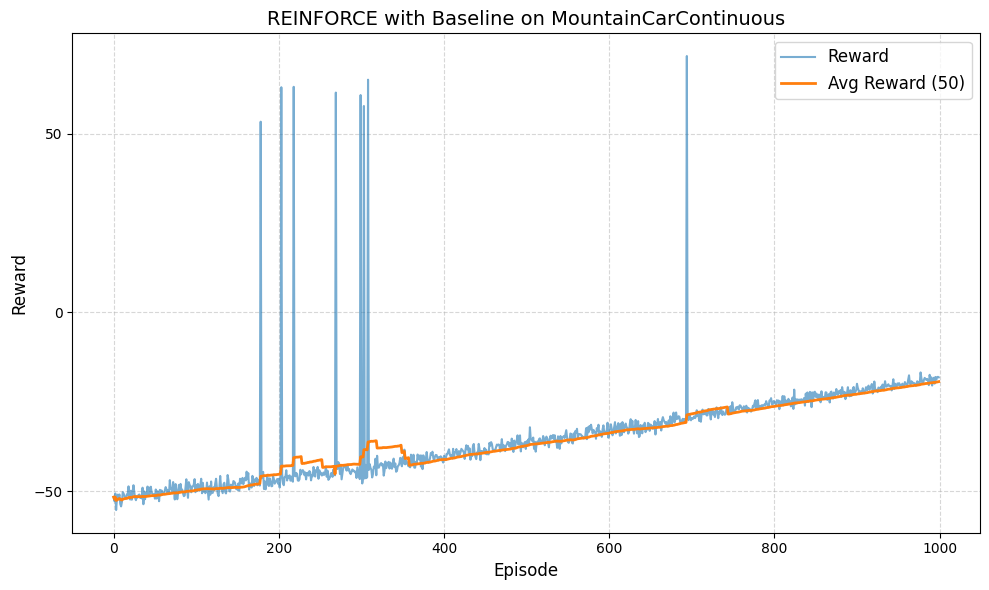

In [31]:
train_agent()

In [32]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        return self.net(state).squeeze(-1)  # Output shape: (batch,)

In [33]:
class REINFORCEAgentWithBaseline:
    def __init__(self, env, gamma=0.99, policy_lr=1e-3, value_lr=1e-3):
        self.env = env
        self.gamma = gamma

        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]

        self.policy = PolicyNetwork(obs_dim, act_dim)
        self.value = ValueNetwork(obs_dim)

        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=value_lr)

    def discount_rewards(self, rewards):
        discounted = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            discounted.insert(0, R)
        return torch.tensor(discounted, dtype=torch.float32)

    def train_episode(self):
        states = []
        actions = []
        log_probs = []
        rewards = []

        state, _ = self.env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = self.policy.get_action(state)
            next_state, reward, done, truncated, _ = self.env.step(action)

            states.append(torch.from_numpy(state).float())
            actions.append(torch.from_numpy(action).float())
            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state
            total_reward += reward

        # Convert to tensors
        states = torch.stack(states)
        log_probs = torch.stack(log_probs)
        returns = self.discount_rewards(rewards)

        # Value predictions and advantages
        values = self.value(states)
        advantages = returns - values.detach()

        # Policy loss: REINFORCE with baseline
        policy_loss = -torch.sum(log_probs * advantages)

        # Value loss: MSE
        value_loss = nn.functional.mse_loss(values, returns)

        # Update policy
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Update value network
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        return total_reward

In [34]:
def train_agent_with_baseline():
    env = gym.make("MountainCarContinuous-v0")
    agent = REINFORCEAgentWithBaseline(env)

    num_episodes = 1000
    rewards = []
    avg_rewards = []

    for episode in range(num_episodes):
        reward = agent.train_episode()
        rewards.append(reward)
        avg_reward = np.mean(rewards[-50:])
        avg_rewards.append(avg_reward)

        print(f"Episode {episode + 1}: Reward = {reward:.2f}, Avg(50) = {avg_reward:.2f}")
        if avg_reward >= 90.0:
            print("Environment solved!")
            break

    # Improved Plot with y-axis increments of 50
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Reward', color='tab:blue', alpha=0.6)
    plt.plot(avg_rewards, label='Avg Reward (50)', color='tab:orange', linewidth=2)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.title('REINFORCE with Baseline on MountainCarContinuous', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50))
    plt.tight_layout()
    plt.show()

Episode 1: Reward = -34.49, Avg(50) = -34.49
Episode 2: Reward = -46.34, Avg(50) = -40.42
Episode 3: Reward = -80.29, Avg(50) = -53.71
Episode 4: Reward = 5.77, Avg(50) = -38.84
Episode 5: Reward = -25.91, Avg(50) = -36.25
Episode 6: Reward = -332.60, Avg(50) = -85.64
Episode 7: Reward = -176.74, Avg(50) = -98.66
Episode 8: Reward = 28.49, Avg(50) = -82.76
Episode 9: Reward = -8.70, Avg(50) = -74.53
Episode 10: Reward = -56.07, Avg(50) = -72.69
Episode 11: Reward = 26.51, Avg(50) = -63.67
Episode 12: Reward = -19.47, Avg(50) = -59.99
Episode 13: Reward = 18.68, Avg(50) = -53.93
Episode 14: Reward = -146.09, Avg(50) = -60.52
Episode 15: Reward = 50.80, Avg(50) = -53.10
Episode 16: Reward = 59.61, Avg(50) = -46.05
Episode 17: Reward = 8.68, Avg(50) = -42.83
Episode 18: Reward = -59.76, Avg(50) = -43.77
Episode 19: Reward = 24.91, Avg(50) = -40.16
Episode 20: Reward = 11.14, Avg(50) = -37.59
Episode 21: Reward = 43.25, Avg(50) = -33.74
Episode 22: Reward = -11.26, Avg(50) = -32.72
Episode

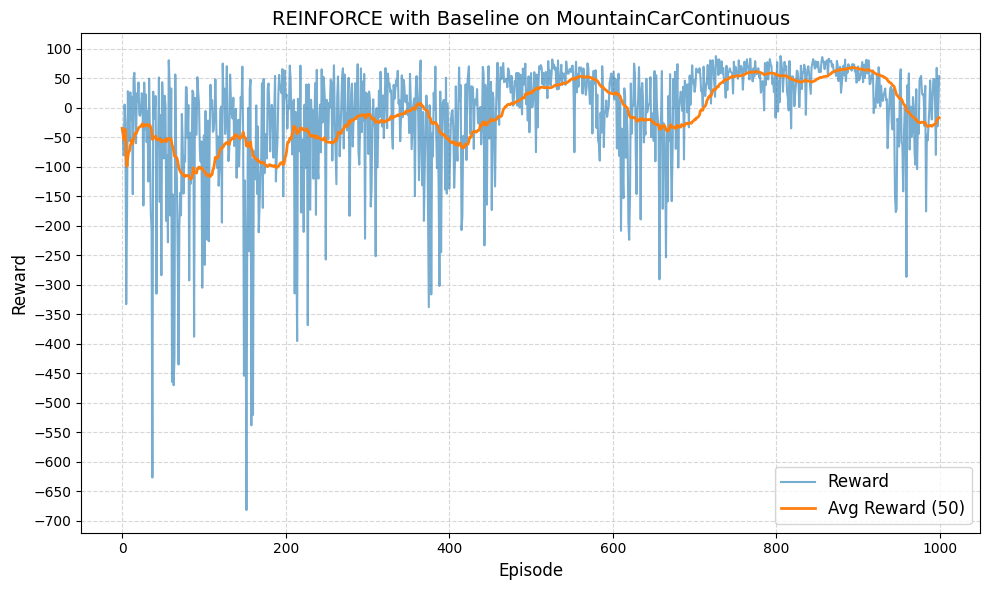

In [35]:
train_agent_with_baseline()